In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pickle
import json
from no_stocks_distribution_model import *
import matplotlib.pyplot as plt
#import statsmodels.tsa.stattools as ts
from init_objects import *
from functions.stylizedfacts import *
from functions.helpers import organise_data
#from functions.evolutionaryalgo import quadratic_loss_function
from functions.inequality import gini, lorenz_curve
from distribution_model import *

import statsmodels.api as sm
from SALib.sample import latin
from matplotlib import style
from collections import OrderedDict
from functions.indirect_calibration import distr_model_performance
import seaborn as sns
import scipy.stats as stats
import scipy
from functions.find_bubbles import *
from statsmodels.iolib.summary2 import summary_col

In [2]:
style.use('ggplot')

# Experiment change share of chartists. 

In [31]:
with open('parameters.json', 'r') as f:
    params = json.loads(f.read())

In [32]:
params

{'ticks': 850,
 'fundamental_value': 166,
 'n_traders': 500,
 'std_fundamental': 0.0530163128919286,
 'spread_max': 0.004087,
 'init_stocks': 50,
 'trader_sample_size': 19,
 'horizon': 100,
 'trades_per_tick': 3,
 'std_noise': 0.15863974,
 'w_random': 0.056454,
 'strat_share_chartists': 0.20454462,
 'base_risk_aversion': 6.05054016,
 'fundamentalist_horizon_multiplier': 2.22042767,
 'mutation_intensity': 0.47684635,
 'average_learning_ability': 0.9962696}

Fix the learning ability at 0.0

In [57]:
params['average_learning_ability'] = 0.0
params['mutation_intensity'] = 0.0
params['ticks'] = 850
params['fundamentalist_horizon_multiplier'] = 0.5

In [58]:
NRUNS = 1

Increment the share of chartists from 0.0 to 100

In [59]:
share_chartists = [x / 100.0 for x in range(5, 105, 5)]

In [60]:
Experiments = len(share_chartists)

In [61]:
Experiments

20

## Run model and update share chartists every time

In [62]:
trdrs = []
orbs = []
for exp in range(Experiments):
    params['strat_share_chartists'] = share_chartists[exp]
    for seed in range(NRUNS): 
        traders, orderbook = init_objects_distr(params, seed)
        #traders, orderbook = pb_distr_model(traders, orderbook, params, seed)
        traders, orderbook = pb_distr_model_no_stocks(traders, orderbook, params, seed)
        trdrs.append(traders)
        orbs.append(orderbook)

Start of simulation  0
Start of simulation  0
Start of simulation  0
Start of simulation  0
Start of simulation  0
Start of simulation  0
Start of simulation  0
Start of simulation  0
Start of simulation  0
Start of simulation  0
Start of simulation  0
Start of simulation  0
Start of simulation  0
Start of simulation  0
Start of simulation  0
Start of simulation  0
Start of simulation  0
Start of simulation  0
Start of simulation  0
Start of simulation  0


In [63]:
full_share_chartists = []
for exp in range(Experiments):
    for seed in range(NRUNS):
        full_share_chartists.append(share_chartists[exp])

Structure the data

In [64]:
ginis = []
palmas = []
twtws = []
asset_price_inflation = []
price_to_div_stdev = []

for idx, traders in enumerate(trdrs):
    #print(t)
    money = np.array([x.var.money[-1] for x in trdrs[idx]])
    stocks = np.array([x.var.stocks[-1] for x in trdrs[idx]])
    wealth = money + (stocks * orbs[idx].tick_close_price[-1])
    
    asset_price_inflation.append(orbs[idx].tick_close_price[-1] - orbs[idx].tick_close_price[0])
    price_to_div_stdev.append((pd.Series(orbs[idx].tick_close_price) / pd.Series(orbs[idx].fundamental[1:])).std())
    
    share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
    share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)
    palmas.append(share_top_10 / share_bottom_40)
    
    share_top_20 = sum(np.sort(wealth)[int(len(wealth) * 0.8):]) / sum(wealth)
    share_bottom_20 = sum(np.sort(wealth)[:int(len(wealth) * 0.2)]) / sum(wealth)
    twtws.append(share_top_20 / share_bottom_20)
    
    ginis.append(gini(wealth))

Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation
Negative values founds, check calculation


In [ ]:
# store simulated stylized facts
mc_prices, mc_returns, mc_autocorr_returns, mc_autocorr_abs_returns, mc_volatility, mc_volume, mc_fundamentals = organise_data(
    orbs, burn_in_period=100)

obs = len(mc_fundamentals[0])
r0 = 0.01 + 1.8 / np.sqrt(obs)
swindow0 = int(math.floor(r0 * obs))
dim = obs - swindow0 + 1
IC = 2
adflag = 6
yr = 2
Tb = 12 * yr + swindow0 - 1
nboot = 99

perc_bubble_occur = []

for idx, col in enumerate(mc_returns):
    pds = pd.Series(mc_prices[idx][:-1] / mc_fundamentals[idx])

    obs = len(pds)
    dim = obs - swindow0 + 1

    bsadfs = PSY(pds, swindow0, IC, adflag)
    quantilesBsadf = cvPSYwmboot(pds, swindow0, IC, adflag, Tb, nboot)
    monitorDates = pds.iloc[swindow0 - 1:obs].index
    quantile95 = np.dot(np.array([quantilesBsadf]).T, np.ones([1, dim]))
    ind95 = (bsadfs.T[0] > quantile95[1,])
    periods = monitorDates[ind95]

    if True in ind95:
        bubbly_dates = find_sequences_ints(periods, monitorDates)
        perc_bubble_occur.append(len(periods) / float(len(monitorDates)))
    else: 
        perc_bubble_occur.append(0.0)

In [52]:
# data = pd.DataFrame({'gini': np.log(ginis[:]), 'palma': np.log(palmas[:]), 'twtw': np.log(twtws[:]), 'pd_vol': price_to_div_stdev[:],
#                      'share_chartists': np.log(full_share_chartists[:]), 'perc_b_occur': perc_bubble_occur,
#                      'lin_share_chartists': full_share_chartists[:], 'asset_price_infl': asset_price_inflation[:]})

data = pd.DataFrame({'gini': np.log(ginis[:]), 'palma': np.log(palmas[:]), 'twtw': np.log(twtws[:]), 'pd_vol': price_to_div_stdev[:],
                     'share_chartists': np.log(full_share_chartists[:]),
                     'lin_share_chartists': full_share_chartists[:], 'asset_price_infl': asset_price_inflation[:]})
data['const'] = 1

c:\users\joerischasfoort\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


In [65]:
# Get the t-critical value**
def confidence_interval(sample, emp_value):
    """Calculate confidence_interval in sample"""
    z_critical = stats.norm.ppf(q = 0.99)
    stdev = pd.Series(sample).std()
    margin_of_error = z_critical * stdev
    confidence_interval = (emp_value - margin_of_error, emp_value + margin_of_error)  
    return confidence_interval

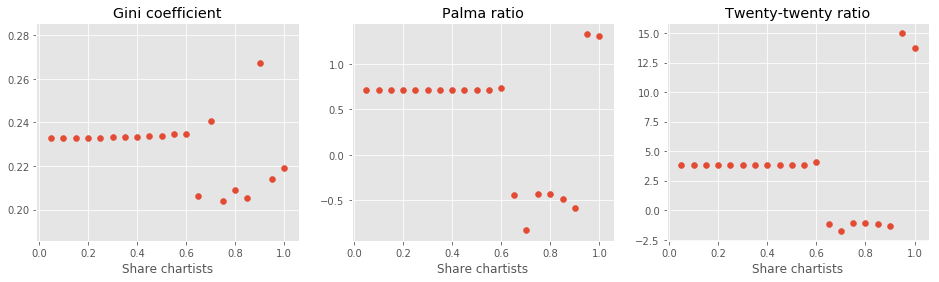

In [67]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[16,4])

# ax1.scatter(range(len(ginis)), ginis)
# ax2.scatter(range(len(palmas)), palmas)
# ax3.scatter(range(len(twtws)), twtws)

ax1.scatter(data['lin_share_chartists'], ginis)
ax2.scatter(data['lin_share_chartists'], palmas)
ax3.scatter(data['lin_share_chartists'], twtws)
#ax2.scatter(range(len(palmas)), palmas)
#ax3.scatter(range(len(twtws)), twtws)

ax3.set_title('Twenty-twenty ratio')
ax2.set_title('Palma ratio')
ax1.set_title('Gini coefficient')

for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('Share chartists')

#fig.savefig('share_chartists_inequality.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

In [ ]:
pd.Series(perc_bubble_occur).plot()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16,4])

ax1.scatter(data['lin_share_chartists'], asset_price_inflation)
ax2.scatter(data['lin_share_chartists'], perc_bubble_occur)


ax1.set_title('Asset_price_inflation')
ax2.set_title('Percentage bubble occur')

for ax in [ax1, ax2]:
    ax.set_xlabel('Share chartists')
    
fig.savefig('share_chartists_prices_bubbles.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

## Regression


In [22]:
gini_res = sm.OLS(endog=data['gini'], exog=data[['const', 'share_chartists']], missing='drop').fit()
palma_res = sm.OLS(endog=data['palma'], exog=data[['const', 'share_chartists']], missing='drop').fit()
twtw_res = sm.OLS(endog=data['twtw'], exog=data[['const', 'share_chartists']], missing='drop').fit()
asset_p_inf_res = sm.OLS(endog=data['asset_price_infl'], exog=data[['const', 'lin_share_chartists']], missing='drop').fit()
#pd_stdev_res = sm.OLS(endog=data['pd_vol'], exog=data[['const', 'lin_share_chartists']], missing='drop').fit()
#perc_bubble_res = sm.OLS(endog=data['perc_b_occur'], exog=data[['const', 'share_chartists']], missing='drop').fit()

In [24]:
info_dict={'R-squared' : lambda x: "{}".format(x.rsquared), 
           'No. observations' : lambda x: "{}".format(int(x.nobs))}

results_table = summary_col(results=[gini_res, palma_res, twtw_res],
                            float_format='%0.4f',
                            stars = True,
                            model_names=['Gini', 'Palma', '20-20'],
                            info_dict=info_dict,
                            regressor_order=['const', 'share_chartists'])

results_table.add_title('Table - OLS Regressions')

print(results_table)

                          Table - OLS Regressions
                         Gini               Palma              20-20       
---------------------------------------------------------------------------
const            -1.4957***          0.0415              1.9169***         
                 (0.0152)            (0.0776)            (0.1064)          
share_chartists  -0.0233*            0.1901***           0.3146***         
                 (0.0128)            (0.0541)            (0.0733)          
R-squared        0.05393482046697562 0.24539021387486104 0.3321805549618282
No. observations 60                  40                  39                
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [ ]:
# info_dict={'R-squared' : lambda x: "{}".format(x.rsquared), 
#            'No. observations' : lambda x: "{}".format(int(x.nobs))}

# results_table = summary_col(results=[gini_res, palma_res, twtw_res, asset_p_inf_res, perc_bubble_res],
#                             float_format='%0.4f',
#                             stars = True,
#                             model_names=['Gini', 'Palma', '20-20', 'Asset-price inflation', 'Bubble occur'],
#                             info_dict=info_dict,
#                             regressor_order=['const', 'share_chartists'])

# results_table.add_title('Table - OLS Regressions')

# print(results_table)

# Experiment 2

Hypothesis, income inequality is a consequence of price fluctuations: 

Everyone is a fundamentalist. High noise 

In [19]:
params['strat_share_chartists'] = 0.001
params['average_learning_ability'] = 0.0
params['fundamentalist_horizon_multiplier'] = 0.2

In [23]:
stdev_fundamental = [x / 10.0 for x in range(5, 105, 20)]

In [26]:
trdrs = []
orbs = []
for seed in range(NRUNS): 
    params['std_fundamental'] = stdev_fundamental[seed]
    traders, orderbook = init_objects_distr(params, seed)
    traders, orderbook = pb_distr_model(traders, orderbook, params, seed)
    trdrs.append(traders)
    orbs.append(orderbook)

Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4


In [27]:
ginis = []
palmas = []
twtws = []
asset_price_inflation = []
price_to_div_stdev = []

for idx, traders in enumerate(trdrs):
    #print(t)
    money = np.array([x.var.money[-1] for x in trdrs[idx]])
    stocks = np.array([x.var.stocks[-1] for x in trdrs[idx]])
    wealth = money + (stocks * orbs[idx].tick_close_price[-1])
    
    asset_price_inflation.append(orbs[idx].tick_close_price[-1] - orbs[idx].tick_close_price[0])
    price_to_div_stdev.append((pd.Series(orbs[idx].tick_close_price) / pd.Series(orbs[idx].fundamental[1:])).std())
    
    share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
    share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)
    palmas.append(share_top_10 / share_bottom_40)
    
    share_top_20 = sum(np.sort(wealth)[int(len(wealth) * 0.8):]) / sum(wealth)
    share_bottom_20 = sum(np.sort(wealth)[:int(len(wealth) * 0.2)]) / sum(wealth)
    twtws.append(share_top_20 / share_bottom_20)
    
    ginis.append(gini(wealth))

In [28]:
data = pd.DataFrame({'gini': np.log(ginis[1:]), 'palma': np.log(palmas[1:]), 'twtw': np.log(twtws[1:]), 'pd_vol': price_to_div_stdev[1:],
                     'stdev_fund': np.log(stdev_fundamental[1:]), 'lin_stdev_fund': stdev_fundamental[1:], 'asset_price_infl': asset_price_inflation[1:]})
data['const'] = 1

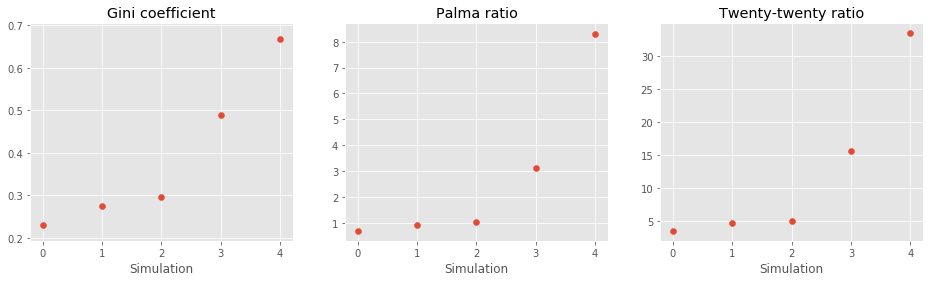

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[16,4])

ax1.scatter(range(len(ginis)), ginis)
ax2.scatter(range(len(palmas)), palmas)
ax3.scatter(range(len(twtws)), twtws)

ax3.set_title('Twenty-twenty ratio')
ax2.set_title('Palma ratio')
ax1.set_title('Gini coefficient')

for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('Simulation')


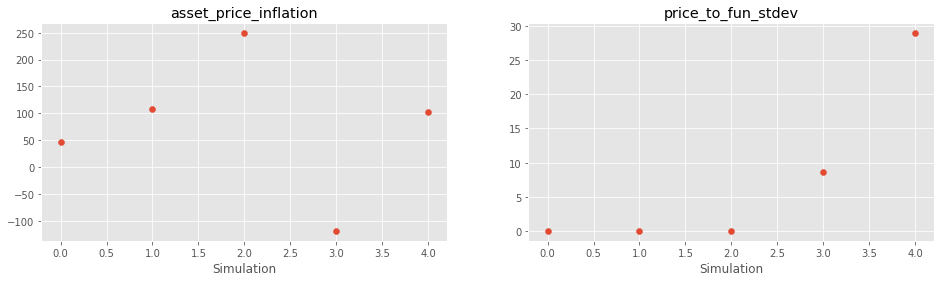

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16,4])

ax1.scatter(range(len(asset_price_inflation)), asset_price_inflation)
ax2.scatter(range(len(price_to_div_stdev)), price_to_div_stdev)


ax1.set_title('asset_price_inflation')
ax2.set_title('price_to_fun_stdev')

for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('Simulation')

Text(0, 0.5, 'PF ratio')

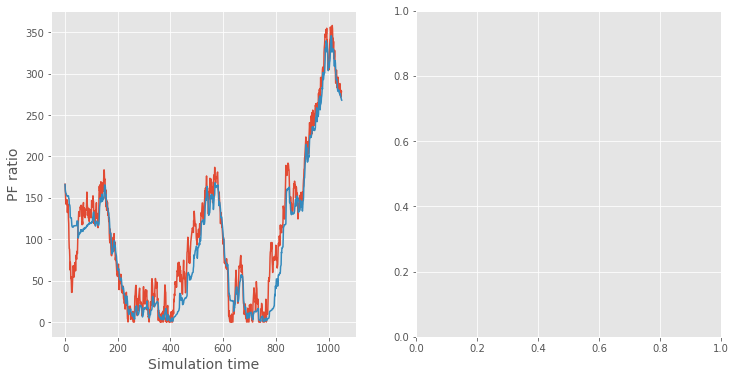

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

#ax1.plot(mc_returns.index, mc_returns[1], label='returns')
ax1.plot(range(len(orbs[idx].fundamental[1:])), orbs[idx].fundamental[1:], label='fundamental')
ax1.plot(range(len(orbs[idx].tick_close_price[1:])), orbs[idx].tick_close_price[1:], label='fundamental')

ax1.set_xlabel('Simulation time', fontsize='14')
ax1.set_ylabel('PF ratio', fontsize='14')

